# Get all the Data from URL

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.utils import resample
warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/anyweez/getsubsalt.com/main/jobs/data-science/challenge/crime.csv"
data = pd.read_csv(url)

In [2]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [3]:
data.isna().sum()

date                     0
primary_type             0
location_description    49
district                28
ward                     8
domestic                 0
arrest                   0
dtype: int64

# Dropping all the NA values since they are very few of them

In [4]:
data.dropna(inplace=True)

In [5]:
#filter out columns where target variables is "?"

data = data[data['arrest'] != '?']

In [6]:
data.shape

(899961, 7)

In [7]:
data.nunique()

date                    352917
primary_type                31
location_description       124
district                    24
ward                        51
domestic                     3
arrest                       2
dtype: int64

# Unique count of all columns. Show high cardinality for location_description and ward

In [8]:
data['arrest']  = data['arrest'].map(lambda x: 1 if x == 'True' else 0)


In [9]:
data.columns

Index(['date', 'primary_type', 'location_description', 'district', 'ward',
       'domestic', 'arrest'],
      dtype='object')

# Create new features out fo date --> Month, Day , Weekend , hour

In [10]:
import datetime

def get_month(row):

  #print("here")
  #print(row)
  date = row['date']
  date = date.replace("UTC","")
  date=date.strip()
  try:
      datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
      return datetime_obj.month
  except:
      return "?"



def get_hour(row):

  #print("here")
  #print(row)
  date = row['date']
  date = date.replace("UTC","")
  date=date.strip()
  try:
      datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
      return datetime_obj.hour
  except:
      return "?"

def is_weekend(row):

  date = row['date']
  date = date.replace("UTC","")
  date=date.strip()

  try:
        datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

        day_of_week = datetime_obj.weekday()
        # Determine if it's a weekday or a weekend
        if day_of_week < 5:
                  day_type = 0
        else:
                  day_type = 1

        return day_type
  except:
        return "?"

def day_of_week(row):

  date = row['date']
  date = date.replace("UTC","")
  date=date.strip()

  try:
        datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        day_of_week = datetime_obj.weekday()
        return day_of_week
  except:
        return "?"



data['month'] = data.apply(get_month,axis=1)
data['hour'] = data.apply(get_hour,axis=1)
data['is_weekend'] = data.apply(is_weekend,axis=1)
data['day'] = data.apply(day_of_week,axis=1)

# Part 1 Data imputation strategy for categorical variables is as follows.

1. Replace "?" with "Missing" so adding a new category for Missing Values
2. We do frequency encoding for month, hour, location, district and ward
3. Those variables have high cardinality so if we do one hot encoding that will make our dataset very sparse.
4.  We use one hot encoding for "domestic" and "primary_type", They dont have high cardinality. Also below charts indicate that they are very important features.
5. If had more time i would use more sophisticated encoding methods like KNN to impute the missing values
6. If I had more time i would use Ray for feature Engineering as well

In [11]:
#data_cat = data[['month','location_description','district','ward','hour']]
data = data.replace("?","Missing")


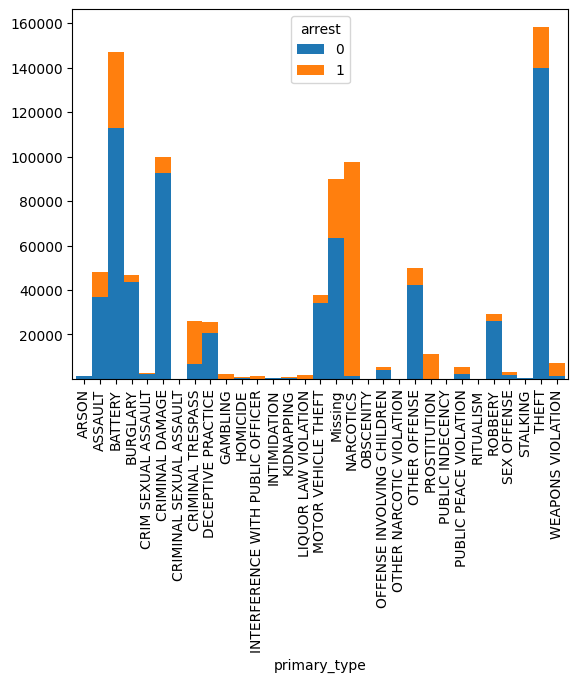

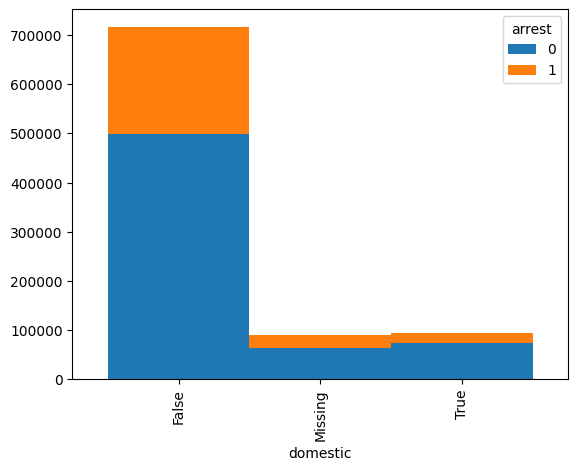

In [12]:
for cols in ['primary_type','domestic']:
 (data.groupby(cols).arrest.value_counts()
   .unstack().plot.bar(width=1,stacked=True))

In [13]:
enc_month = (data.groupby('month').size()) / len(data)
enc_hour = (data.groupby('hour').size()) / len(data)
enc_location_description = (data.groupby('location_description').size()) / len(data)
enc_district = (data.groupby('district').size()) / len(data)
enc_ward = (data.groupby('ward').size()) / len(data)

data['month_encode'] = data['month'].apply(lambda x : enc_month[x])
data['hour_encode'] = data['hour'].apply(lambda x : enc_hour[x])
data['location_description_encode'] = data['location_description'].apply(lambda x : enc_location_description[x])
data['district_encode'] = data['district'].apply(lambda x : enc_district[x])
data['ward_encode'] = data['ward'].apply(lambda x : enc_ward[x])

In [14]:
data.drop(['date','location_description','district','ward','month','is_weekend','day','hour'],axis=1,inplace=True)

In [15]:
def map_domestic(x):

  if x == 'True':
    return "yes"
  elif x == 'False':
    return "no"
  else:
    return "missing"


In [16]:
data['domestic_map'] = data['domestic'].map(lambda x: map_domestic(x))

#no of positive classes #264041

In [17]:
data['arrest'].sum()

264041

In [18]:
data[data['arrest'] == 0].count()

primary_type                   635920
domestic                       635920
arrest                         635920
month_encode                   635920
hour_encode                    635920
location_description_encode    635920
district_encode                635920
ward_encode                    635920
domestic_map                   635920
dtype: int64

In [19]:
#Trying to upsample the data due imbalance nature
data_pos = data[data['arrest'] == 1]
data_neg = data[data['arrest'] == 0]
data_pos_upsampled = resample(data_pos,
                                 replace=True,
                                 n_samples=635920)

data=pd.concat([data_neg,data_pos_upsampled])

In [20]:
data.shape

(1271840, 9)

In [21]:
y = data['arrest']
data.drop(['domestic','arrest'],axis=1,inplace=True)


# Creating dummy variables for features domestic and arrest

In [22]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['primary_type','domestic_map'])

In [23]:
X  = one_hot_encoded_data*1

In [24]:
len(X.columns)

39

In [25]:
# for data imputation we call it missing data

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings

In [27]:
X.shape

(1271840, 39)

In [28]:
y.shape

(1271840,)

In [29]:
y.sum()

635920

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Part 2 Training Supervised Learning


1.   I tried 3 models Logistic Regression, Random Forest, Xgboost
2.   I choose Precision, Recall , F1 score, Accuracy as measure and used cross validation
3.   I have tried upsampling to balance the data. If i had more time i would try other techniques like downsampling and smote as well.
4.  I would have tried RAY of Ditributed Training as well if i had more time

# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logisticRegr = LogisticRegression()

recall = cross_val_score(logisticRegr, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(logisticRegr, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(logisticRegr, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.618484073928431 [0.61742037 0.61859025 0.61641762 0.62368266 0.61630948]
Precision 0.8641937942547401 [0.86349887 0.86482586 0.86267766 0.86424815 0.86571843]
F1 0.7209758599850503 [0.72001467 0.72127145 0.71904726 0.72451835 0.72002756]


# Random Forest Classifier

In [32]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the classifier
recall = cross_val_score(rf_classifier , X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(rf_classifier , X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(rf_classifier , X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.8872335823830122 [0.88758356 0.8861974  0.88628588 0.8895989  0.88650216]
Precision 0.8744587276283369 [0.87633219 0.87502305 0.87412615 0.87363269 0.87317956]
F1 0.8807989451723486 [0.88192199 0.88057478 0.88016402 0.8815435  0.87979043]


In [33]:
!pip install xgboost

In [34]:
import xgboost as xgb

# Xgboost classifier

In [35]:
clf = xgb.XGBClassifier()
# X is the dataframe we created in previous snippet

recall = cross_val_score(clf , X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf , X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf , X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.6975462052693668 [0.69397365 0.6983779  0.69589068 0.7021628  0.69732599]
Precision 0.8764615825639724 [0.87775733 0.87513397 0.87569587 0.87773586 0.87598488]
F1 0.7768322964348338 [0.77512051 0.77682823 0.77550752 0.78019367 0.77651154]


In [36]:
acc = cross_val_score(clf , X_train, y_train, cv=5, scoring='accuracy')
print('Accuracy Xgboost', np.mean(acc), acc)
acc = cross_val_score(rf_classifier , X_train, y_train, cv=5, scoring='accuracy')
print('Accuracy Random Forest', np.mean(acc), acc)
acc = cross_val_score(logisticRegr, X_train, y_train, cv=5, scoring='accuracy')
print('Accuracy. Logistic Regression', np.mean(acc), acc)


Accuracy Xgboost 0.7996662327758595 [0.79871741 0.79942013 0.79860831 0.80223004 0.79935526]
Accuracy Random Forest 0.8799603319598497 [0.8811961  0.87984471 0.87936254 0.88049279 0.87890552]
Accuracy. Logistic Regression 0.7607088946202957 [0.75997445 0.76101624 0.75921157 0.76292176 0.76042045]


# PART 3 Scaling Scoring using RAY on large dataset


1.   I used upsampling to increase size of test data
2.   Increased the size to 10 Million rows. Ray was able to do that very fast using parallel processing



In [37]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [38]:
X_test.shape

(254368, 39)

# Splitting DataFrame into chunks for parallel procession

In [39]:
def split_dataframe(df, chunk_size = 10000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [40]:
from sklearn.utils import resample

In [41]:
X_test_upsampled = resample(X_test,
                                 replace=True,
                                 n_samples=1000000)

In [42]:
X_test_upsampled

,month_encode,hour_encode,location_description_encode,district_encode,ward_encode,primary_type_ARSON,primary_type_ASSAULT,primary_type_BATTERY,primary_type_BURGLARY,primary_type_CRIM SEXUAL ASSAULT,...,primary_type_PUBLIC PEACE VIOLATION,primary_type_RITUALISM,primary_type_ROBBERY,primary_type_SEX OFFENSE,primary_type_STALKING,primary_type_THEFT,primary_type_WEAPONS VIOLATION,domestic_map_missing,domestic_map_no,domestic_map_yes
606501,0.071670,0.056379,0.170584,0.100245,0.016095,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
356928,0.064726,0.105409,0.241426,0.040236,0.020381,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
437080,0.084259,0.070365,0.241426,0.100245,0.033249,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
723569,0.100181,0.100181,0.089014,0.063915,0.026347,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
396295,0.077978,0.088032,0.021274,0.038413,0.009483,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0.074212,0.061134,0.170584,0.037085,0.032540,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
775562,0.079037,0.058270,0.099909,0.100245,0.020381,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
830704,0.079037,0.058270,0.033211,0.100245,0.032540,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
987765,0.082581,0.072252,0.097541,0.100245,0.033249,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
len(X_test_upsampled)

1000000

In [44]:
chunks = split_dataframe(X_test_upsampled)

In [50]:
chunks=chunks[0:100]

In [45]:
!pip install ray


In [46]:
import ray

In [51]:
@ray.remote

def make_predictions(model,batch):

  predictions = model.predict(batch)
  return predictions

model_ref = ray.put(rf_classifier)

results_ref = []

for chunk in chunks:

  results_ref.append(make_predictions.remote(model_ref, chunk))


results = ray.get(results_ref)


In [52]:
len(results[0])

10000

In [53]:
len(results)

100

In [54]:
from sklearn.metrics import roc_auc_score

# Overall Random Forest Gives Impressive Results
# Accracy : 89
# Recall : 0.89
# Precision : 0.88
# F1 : 0.88

In [ ]:
#roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

In [ ]:
#roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])